# Creating plot to see how the number of positive cases changes based on the time in ED

Justifying why we chose the 24 hour time.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# read in files
datadir = "/home/eulalio/BMI212/2019_data/SHCcore_Data"

cohort_file = "{}/cohort_demo_final.csv".format(datadir)

cohort = pd.read_csv(cohort_file)


In [3]:
cohort

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,ESI_i,delta_ESI,gender,age,medis,...,RR,SpO2,Temp,race.Asian,race.Black,race.Native.American,race.Other,race.Pacific.Islander,race.Unknown,race.White
0,JC29f8ad2,131274729058,40679773,0,2019-08-31 12:52:00,3,0,1,52,0,...,20,99,36.95,0,0,0,0,0,0,1
1,JC29f8ad3,131278291027,42992239,0,2019-10-05 23:48:00,3,0,1,35,0,...,18,99,36.85,1,0,0,0,0,0,0
2,JC29f8b9c,131266787806,36261582,0,2019-05-05 01:07:00,2,0,0,59,1,...,26,74,39.20,0,0,0,0,0,1,0
3,JC29f8beb,131264387263,34626013,0,2019-03-15 03:35:00,3,0,1,30,0,...,16,98,37.05,0,0,0,0,0,0,1
4,JC29f8beb,131279241689,43527040,0,2019-11-27 15:29:00,3,0,1,30,0,...,18,99,37.05,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41649,JCec4839,131225960399,24250419,0,2017-03-30 17:45:00,2,0,0,60,0,...,16,100,37.00,0,0,0,0,0,0,1
41650,JCec4839,131226354387,24301429,1,2017-04-03 16:45:00,2,0,0,60,0,...,16,93,36.00,0,0,0,0,0,0,1
41651,JCec4853,131273484812,39876896,0,2019-07-03 00:42:00,2,0,0,47,0,...,24,97,37.05,0,0,0,0,0,0,1
41652,JCec4865,131223770345,23975967,0,2017-04-11 23:37:00,3,0,1,29,0,...,18,99,37.00,0,0,0,1,0,0,0


In [4]:
adjusted_cohort_adt.effective_time_jittered_utc

NameError: name 'adjusted_cohort_adt' is not defined

In [5]:
df_admit_times = cohort[['pat_enc_csn_id_coded', 'admit_time']]
df_admit_times.admit_time = pd.to_datetime(df_admit_times.admit_time, utc=True)
df_admit_times

/home/eulalio/snap/jupyter/common/lib/python3.7/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,pat_enc_csn_id_coded,admit_time
0,131274729058,2019-08-31 12:52:00+00:00
1,131278291027,2019-10-05 23:48:00+00:00
2,131266787806,2019-05-05 01:07:00+00:00
3,131264387263,2019-03-15 03:35:00+00:00
4,131279241689,2019-11-27 15:29:00+00:00
...,...,...
41649,131225960399,2017-03-30 17:45:00+00:00
41650,131226354387,2017-04-03 16:45:00+00:00
41651,131273484812,2019-07-03 00:42:00+00:00
41652,131223770345,2017-04-11 23:37:00+00:00


In [6]:
# load in a fresh copy of the adjusted cohort table here

# read in the cohort after saving the first time
adt_file = "/home/eulalio/BMI212/2019_data/triage_cohort_adt_2019.csv"
adjusted_cohort_adt = pd.read_csv(adt_file)

# change the effective time to datetime since read in from csv
adjusted_cohort_adt.effective_time_jittered_utc = pd.to_datetime(adjusted_cohort_adt.effective_time_jittered_utc)

adjusted_cohort_adt.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'], inplace=True)

# use this to hide ID columns from view
hidecols = ['anon_id', 'pat_enc_csn_id_coded']


def get_labels(window_hours):
    # setting up variables to use conor's code
    df_change = adjusted_cohort_adt
    df_lofc = adjusted_cohort_adt
    inpatient_ids = set(adjusted_cohort_adt.pat_enc_csn_id_coded.values)

    # conor's code
#     df_admit_times = df_change[df_change['pat_enc_csn_id_coded'].isin(inpatient_ids)]
#     df_admit_times = df_admit_times[df_admit_times['pat_class'] == 'Inpatient'].groupby(
#          'pat_enc_csn_id_coded').first().reset_index()[['pat_enc_csn_id_coded', 'effective_time_jittered_utc']].rename(
#          columns={'effective_time_jittered_utc' : 'admit_time_jittered'})
#     df_admit_times
    

    # Merge to df_lofc and create column called time_since_admit
    df_lofc = pd.merge(df_lofc, df_admit_times, how='left', on='pat_enc_csn_id_coded')
#     df_lofc['time_since_admit'] = df_lofc.apply(lambda x: x.effective_time_jittered_utc - x.admit_time_jittered, axis=1)
    df_lofc['time_since_admit'] = df_lofc.apply(lambda x: x.effective_time_jittered_utc 
                                                - x.admit_time, axis=1)
   
    # Filter df_lofc so that we only look window_hours hours into admission
    df_lofc = df_lofc[df_lofc['time_since_admit'] < timedelta(hours=window_hours)]

    def was_placed_in_critical_care(arr):
        """Returns true if patient placed in crtical care within 24 hours of admit
           Assumes we have already done the 24 hours logic
           Assumes no overlapping csn ids... """
        for a in arr:
            if a == 'Critical Care':
                return 1
        return 0

    label_name = "label_{}hr".format(window_hours)
    
    df_labels = df_lofc.groupby('pat_enc_csn_id_coded').agg({
        'anon_id' : 'first',
        'admit_time' : 'first',
        'pat_lv_of_care' : was_placed_in_critical_care}).rename(
        columns={"pat_lv_of_care" : label_name}).reset_index()[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', label_name]]
    df_labels.head()

    print(df_labels.groupby(label_name).count())
    
    return df_labels

In [7]:
labels_24hr = get_labels(24)

            anon_id  pat_enc_csn_id_coded  admit_time
label_24hr                                           
0             36086                 36086       36086
1              5568                  5568        5568


# Get Reverse Labels

Get labels that tell us about the movement of people from non-ICU to ICU

In [8]:
def get_reverse_labels(window_hours):
    # setting up variables to use conor's code
    df_change = adjusted_cohort_adt
    df_lofc = adjusted_cohort_adt
    inpatient_ids = set(adjusted_cohort_adt.pat_enc_csn_id_coded.values)


    # Merge to df_lofc and create column called time_since_admit
    df_lofc = pd.merge(df_lofc, df_admit_times, how='left', on='pat_enc_csn_id_coded')
    df_lofc['time_since_admit'] = df_lofc.apply(lambda x: x.effective_time_jittered_utc - x.admit_time, axis=1)
    # Filter df_lofc so that we only look window_hours hours into admission
    df_lofc = df_lofc[df_lofc['time_since_admit'] < timedelta(hours=window_hours)]

    def was_placed_in_critical_care(arr):
        """Returns true if patient placed in crtical care within 24 hours of admit
           Assumes we have already done the 24 hours logic
           Assumes no overlapping csn ids... """
        for a in arr:
            if a == 'Critical Care':
                return 1
        return 0

    label_name = "label_{}hr".format(window_hours)
    
    df_labels = df_lofc.groupby('pat_enc_csn_id_coded').agg({
        'anon_id' : 'first',
        'admit_time' : 'first',
        'pat_lv_of_care' : was_placed_in_critical_care}).rename(
        columns={"pat_lv_of_care" : label_name}).reset_index()[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', label_name]]
    df_labels.head()

    print(df_labels.groupby(label_name).count())
    
    return df_labels

### Connect 24 hour labels to the adjusted_cohort table

These labels should be the same as those already in the table. Use this as a check to make sure we're doing things properly.

Everything matches so we're good!

In [9]:
# read in data files
datadir = "/home/eulalio/BMI212/2019_data/"

csn_file = datadir + "cohort_2019_csns.csv"

csns = pd.read_csv(csn_file)


In [10]:
# filter down to csns in our cohort - should be 41,654 csns
adt = adjusted_cohort_adt[adjusted_cohort_adt.pat_enc_csn_id_coded.isin(csns.pat_enc_csn_id_coded)]

adt.pat_enc_csn_id_coded.nunique()

41654

In [11]:
adt.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,seq_num_in_enc,seq_num_in_bed_min
271568,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00+00:00,1,1.0
271611,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00+00:00,2,1.0
270759,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00+00:00,3,1.0
271607,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00+00:00,4,1.0
270762,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00+00:00,5,1.0


In [12]:
triage_cohort_adjusted = adt[['anon_id', 'pat_enc_csn_id_coded']].drop_duplicates()

In [13]:
# connect the new labels to the adjusted cohort
triage_cohort_adjusted_label24 = triage_cohort_adjusted.merge(labels_24hr, 
                                                             on=['anon_id', 'pat_enc_csn_id_coded']
                                                             )

In [14]:
triage_cohort_adjusted_label24.head()

,anon_id,pat_enc_csn_id_coded,admit_time,label_24hr
0,JCe78a06,131062667066,2015-01-02 01:01:00+00:00,0
1,JCd1c19e,131062745090,2015-01-03 05:53:00+00:00,0
2,JCd91eb2,131062747648,2015-01-01 08:24:00+00:00,0
3,JCe7cb4d,131062788358,2015-01-01 23:39:00+00:00,0
4,JCe293de,131063044001,2015-01-05 02:23:00+00:00,0


# Labels for a range of hours

The next two block take forever to run. Just one once, save, and then read in the saved file after that.

In [15]:
triage_cohort_labels = triage_cohort_adjusted

# get the labels for a range of hours
hours = 48
for i in range(hours):
    print("Getting labels for hour ", i)
    labels = get_labels(i)
    triage_cohort_labels = triage_cohort_labels.merge(labels, 
                                                             on=['anon_id', 'pat_enc_csn_id_coded'])
    
triage_cohort_labels

Getting labels for hour  0
           anon_id  pat_enc_csn_id_coded  admit_time
label_0hr                                           
0            41623                 41623       41623
1               31                    31          31
Getting labels for hour  1
           anon_id  pat_enc_csn_id_coded  admit_time
label_1hr                                           
0            37085                 37085       37085
1             4569                  4569        4569
Getting labels for hour  2
           anon_id  pat_enc_csn_id_coded  admit_time
label_2hr                                           
0            36963                 36963       36963
1             4691                  4691        4691
Getting labels for hour  3
           anon_id  pat_enc_csn_id_coded  admit_time
label_3hr                                           
0            36868                 36868       36868
1             4786                  4786        4786
Getting labels for hour  4
           anon_i

            anon_id  pat_enc_csn_id_coded  admit_time
label_34hr                                           
0             35910                 35910       35910
1              5744                  5744        5744
Getting labels for hour  35
            anon_id  pat_enc_csn_id_coded  admit_time
label_35hr                                           
0             35903                 35903       35903
1              5751                  5751        5751
Getting labels for hour  36
            anon_id  pat_enc_csn_id_coded  admit_time
label_36hr                                           
0             35893                 35893       35893
1              5761                  5761        5761
Getting labels for hour  37
            anon_id  pat_enc_csn_id_coded  admit_time
label_37hr                                           
0             35878                 35878       35878
1              5776                  5776        5776
Getting labels for hour  38
            anon_id  pat

,anon_id,pat_enc_csn_id_coded,admit_time_x,label_0hr,admit_time_y,label_1hr,admit_time_x,label_2hr,admit_time_y,label_3hr,...,admit_time_y,label_43hr,admit_time_x,label_44hr,admit_time_y,label_45hr,admit_time_x,label_46hr,admit_time_y,label_47hr
0,JCe78a06,131062667066,2015-01-02 01:01:00+00:00,0,2015-01-02 01:01:00+00:00,0,2015-01-02 01:01:00+00:00,0,2015-01-02 01:01:00+00:00,0,...,2015-01-02 01:01:00+00:00,0,2015-01-02 01:01:00+00:00,0,2015-01-02 01:01:00+00:00,0,2015-01-02 01:01:00+00:00,0,2015-01-02 01:01:00+00:00,0
1,JCd1c19e,131062745090,2015-01-03 05:53:00+00:00,0,2015-01-03 05:53:00+00:00,0,2015-01-03 05:53:00+00:00,0,2015-01-03 05:53:00+00:00,0,...,2015-01-03 05:53:00+00:00,0,2015-01-03 05:53:00+00:00,0,2015-01-03 05:53:00+00:00,0,2015-01-03 05:53:00+00:00,0,2015-01-03 05:53:00+00:00,0
2,JCd91eb2,131062747648,2015-01-01 08:24:00+00:00,0,2015-01-01 08:24:00+00:00,0,2015-01-01 08:24:00+00:00,0,2015-01-01 08:24:00+00:00,0,...,2015-01-01 08:24:00+00:00,0,2015-01-01 08:24:00+00:00,0,2015-01-01 08:24:00+00:00,0,2015-01-01 08:24:00+00:00,0,2015-01-01 08:24:00+00:00,0
3,JCe7cb4d,131062788358,2015-01-01 23:39:00+00:00,0,2015-01-01 23:39:00+00:00,0,2015-01-01 23:39:00+00:00,0,2015-01-01 23:39:00+00:00,0,...,2015-01-01 23:39:00+00:00,0,2015-01-01 23:39:00+00:00,0,2015-01-01 23:39:00+00:00,0,2015-01-01 23:39:00+00:00,0,2015-01-01 23:39:00+00:00,0
4,JCe293de,131063044001,2015-01-05 02:23:00+00:00,0,2015-01-05 02:23:00+00:00,0,2015-01-05 02:23:00+00:00,0,2015-01-05 02:23:00+00:00,0,...,2015-01-05 02:23:00+00:00,0,2015-01-05 02:23:00+00:00,0,2015-01-05 02:23:00+00:00,0,2015-01-05 02:23:00+00:00,0,2015-01-05 02:23:00+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41649,JCdd7807,131282654066,2019-12-30 10:03:00+00:00,0,2019-12-30 10:03:00+00:00,0,2019-12-30 10:03:00+00:00,0,2019-12-30 10:03:00+00:00,0,...,2019-12-30 10:03:00+00:00,0,2019-12-30 10:03:00+00:00,0,2019-12-30 10:03:00+00:00,0,2019-12-30 10:03:00+00:00,0,2019-12-30 10:03:00+00:00,0
41650,JCe497c6,131282667784,2019-12-29 21:54:00+00:00,0,2019-12-29 21:54:00+00:00,0,2019-12-29 21:54:00+00:00,0,2019-12-29 21:54:00+00:00,0,...,2019-12-29 21:54:00+00:00,0,2019-12-29 21:54:00+00:00,0,2019-12-29 21:54:00+00:00,0,2019-12-29 21:54:00+00:00,0,2019-12-29 21:54:00+00:00,0
41651,JCdd16d2,131282673144,2019-12-31 20:39:00+00:00,0,2019-12-31 20:39:00+00:00,0,2019-12-31 20:39:00+00:00,0,2019-12-31 20:39:00+00:00,0,...,2019-12-31 20:39:00+00:00,0,2019-12-31 20:39:00+00:00,0,2019-12-31 20:39:00+00:00,0,2019-12-31 20:39:00+00:00,0,2019-12-31 20:39:00+00:00,0
41652,JCd92d92,131282708895,2019-12-31 03:19:00+00:00,0,2019-12-31 03:19:00+00:00,1,2019-12-31 03:19:00+00:00,1,2019-12-31 03:19:00+00:00,1,...,2019-12-31 03:19:00+00:00,1,2019-12-31 03:19:00+00:00,1,2019-12-31 03:19:00+00:00,1,2019-12-31 03:19:00+00:00,1,2019-12-31 03:19:00+00:00,1


In [16]:
# get labels for many different hour marks
dropcols = [x for x in triage_cohort_labels.columns if 'admit_time_jittered' in x]
triage_cohort_labels_clean = triage_cohort_labels.drop(dropcols, axis=1)

triage_cohort_labels_clean.to_csv("traige_2019_cohort_all_labels_clean_20210216.csv")


In [17]:
triage_cohort_labels_clean = pd.read_csv("traige_2019_cohort_all_labels_clean_20210216.csv")

Find out how percentage of positive labels change as we move the window to create our labels.

In [18]:

pos_count = []
neg_count = []
cols = []

hours=48
for i in range(hours):
    col = "label_{}hr".format(i)
    cols.append(col)
    labels = triage_cohort_labels_clean[col]
    pos = sum(labels)
    neg = len(labels) - pos
    pos_count.append(pos)
    neg_count.append(neg)

print(pos_count)
print(neg_count)

pos_perc = np.array(pos_count) / (np.array(pos_count) + np.array(neg_count)) * 100
neg_perc = np.array(neg_count) / (np.array(pos_count) + np.array(neg_count)) * 100

print(pos_perc)
print(neg_perc)

[31, 4569, 4691, 4786, 4870, 4949, 5007, 5066, 5121, 5159, 5197, 5227, 5248, 5268, 5297, 5328, 5352, 5385, 5418, 5442, 5466, 5489, 5524, 5549, 5568, 5598, 5612, 5628, 5652, 5667, 5677, 5699, 5717, 5730, 5744, 5751, 5761, 5776, 5790, 5806, 5812, 5829, 5840, 5847, 5875, 5890, 5900, 5911]
[41623, 37085, 36963, 36868, 36784, 36705, 36647, 36588, 36533, 36495, 36457, 36427, 36406, 36386, 36357, 36326, 36302, 36269, 36236, 36212, 36188, 36165, 36130, 36105, 36086, 36056, 36042, 36026, 36002, 35987, 35977, 35955, 35937, 35924, 35910, 35903, 35893, 35878, 35864, 35848, 35842, 35825, 35814, 35807, 35779, 35764, 35754, 35743]
[ 0.07442262 10.96893456 11.26182359 11.48989293 11.69155423 11.88121189
 12.02045422 12.16209728 12.29413742 12.38536515 12.47659288 12.54861478
 12.59903011 12.6470447  12.71666587 12.79108849 12.84870601 12.92793009
 13.00715417 13.06477169 13.12238921 13.17760599 13.26163154 13.32164978
 13.36726365 13.43928554 13.47289576 13.51130744 13.56892495 13.6049359
 13.6289432 

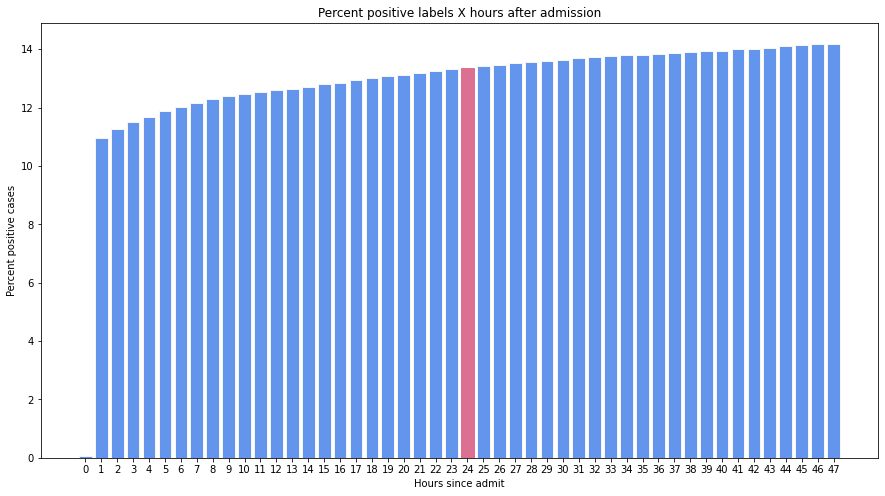

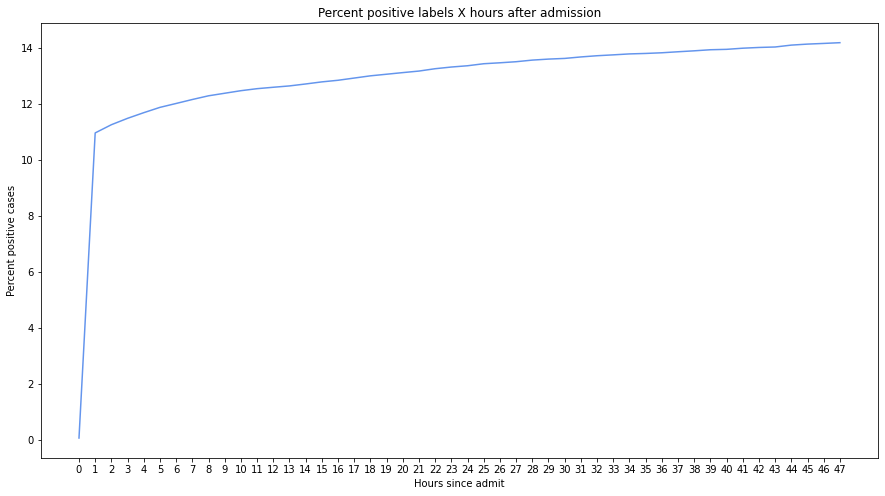

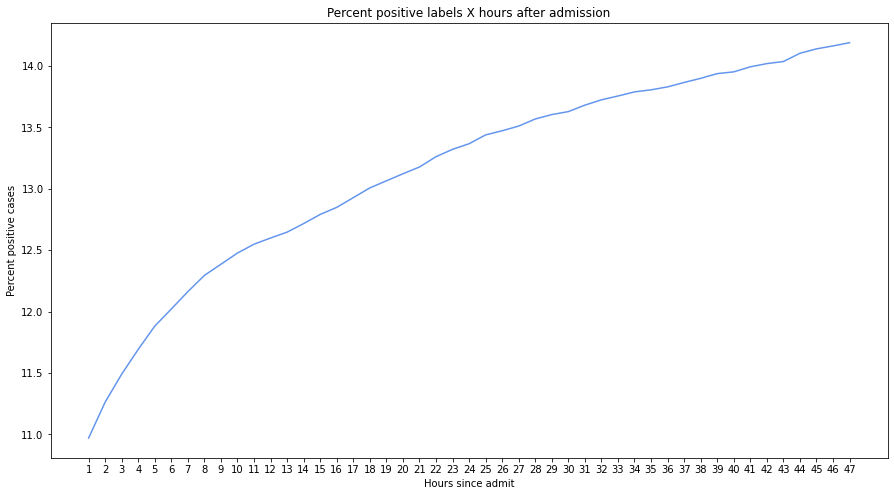

In [19]:
# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.bar(names, pos_perc, color='cornflowerblue', edgecolor='whitesmoke')
barlist[24].set_color('palevioletred')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases")
plt.title("Percent positive labels X hours after admission")
 
# Show graphic
plt.show()


# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, pos_perc, color='cornflowerblue')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases")
plt.title("Percent positive labels X hours after admission")
 
# Show graphic
plt.show()





# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, pos_perc[1:], color='cornflowerblue')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases")
plt.title("Percent positive labels X hours after admission")
 
# Show graphic
plt.show()

In [31]:
pos_count

# get the difference between one hour and the before
pos_count_diff = [pos_count[i+1] - pos_count[i] for i in range(len(pos_count)-1)]

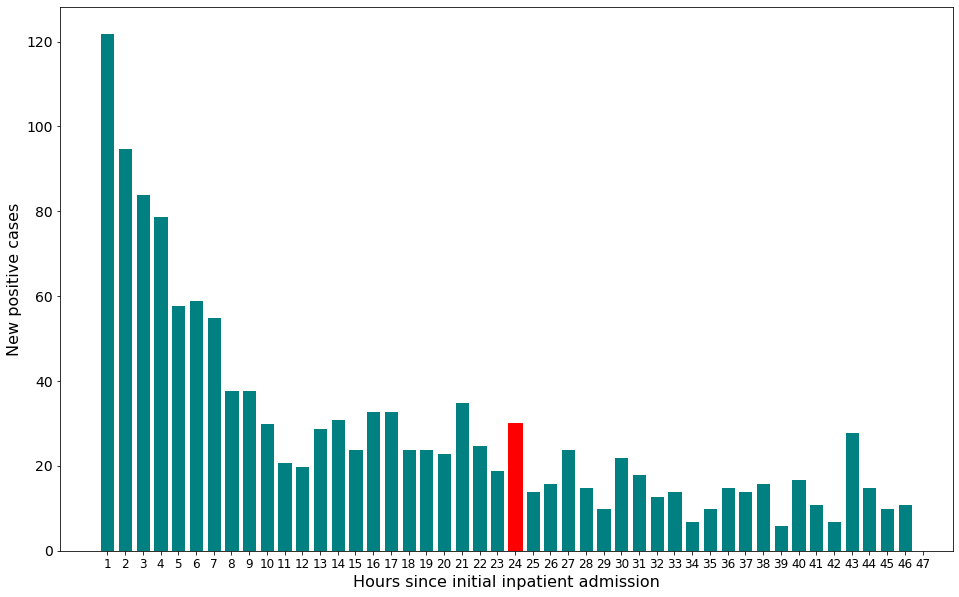

In [53]:
# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(16,10))
# Create green Bars
barlist = plt.bar(names[:-1], pos_count_diff[1:], color=color1, edgecolor='white')
barlist[23].set_color(color2)

# Custom x axis

plt.xticks(names)
# plt.ylim([4000,6000])

plt.xlabel("Hours since initial inpatient admission", fontsize=16)
plt.ylabel("New positive cases", fontsize=16)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=14, rotation=0)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.savefig("traige_2019_positive_cases_noncumulative.png")
plt.show()

In [ ]:
color1 = "teal"
color2 = "red"

# plot
# names = [x for x in range(48)]
# plt.figure(figsize=(10,12))
# # Create green Bars
# barlist = plt.barh(names, pos_count, color=color1, edgecolor='white')
# barlist[24].set_color(color2)

# # Custom x axis

# plt.yticks(names)

# plt.ylabel("Hours since admit", fontsize=16)
# plt.xlabel("Positive cases", fontsize=16)

# plt.yticks(fontsize=14, rotation=0)
# plt.xticks(fontsize=16, rotation=0)
# # plt.title("Positive labels X hours after admission")
 
# # Show graphic
# plt.savefig("traige_2019_postive_cases_horizontal.png", bbox_inches='tight')
# plt.show()



# plot
names = [x for x in range(48)]
plt.figure(figsize=(16,10))
# Create green Bars
barlist = plt.bar(names, pos_count, color=color1, edgecolor='white')
barlist[24].set_color(color2)

# Custom x axis

plt.xticks(names)

plt.xlabel("Hours since initial inpatient admission", fontsize=16)
plt.ylabel("Positive cases", fontsize=16)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=14, rotation=0)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.savefig("traige_2019_positive_cases_vertical.png")
plt.show()



# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(16,10))
# Create green Bars
barlist = plt.bar(names, pos_count[1:], color=color1, edgecolor='white')
barlist[23].set_color(color2)

# Custom x axis

plt.xticks(names)
plt.ylim([4000,6000])

plt.xlabel("Hours since initial inpatient admission", fontsize=16)
plt.ylabel("Positive cases", fontsize=16)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=14, rotation=0)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.savefig("traige_2019_positive_cases_vertical.png")
plt.show()


In [ ]:
# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.barh(names, pos_count, color='slateblue', edgecolor='white')
barlist[24].set_color('r')

# Custom x axis

# plt.xticks(names)
plt.xlabel("Hours since admit", fontsize=16)
plt.ylabel("Positive cases", fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=90)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.show()


# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, pos_count, color='cornflowerblue')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Positive cases")
plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.show()



# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, pos_count[1:], color='cornflowerblue')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit", fontsize=16)
plt.ylabel("Positive cases", fontsize=16)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.show()

In [ ]:
perc24 = pos_perc[24]
perc24

diffs = pos_perc - perc24
diffs

# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.bar(names, diffs, color='dodgerblue', edgecolor='white')
# barlist[24].set_color('crimson')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases at 24hrs - Percent positive cases at X hours")
plt.title("Difference in percentage of positive labels at X hours after admission vs 24 hours after admission")
 
# Show graphic
plt.show()



# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.bar(names, diffs[1:], color='dodgerblue', edgecolor='white')
# barlist[24].set_color('crimson')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases at 24hrs - Percent positive cases at X hours")
plt.title("Difference in percentage of positive labels at X hours after admission vs 24 hours after admission")
 
# Show graphic
plt.show()

In [ ]:
# get the labels for switching
cohort_label24_label12_atc = pd.read_csv("triage_cohort_adjusted_multilabel.csv")

# get those who died
died = triage_adjusted_cohort_deaths[~triage_adjusted_cohort_deaths.death_date_jittered.isnull()]

# join death dates to the atc
died['jc_uid'] = died.rit_uid
joined = cohort_label24_label12_atc.merge(died, on='jc_uid', how='inner')

# find out how much time has passed since admit time and death
joined['admit_time'] = pd.to_datetime(joined.admit_time) 
joined['death_date_jittered'] = pd.to_datetime(joined.death_date_jittered)
# joined['death_date_jittered'] = pd.Timestamp.to_pydatetime(joined.death_date_jittered)
# get the date from admit time
joined['admit_date'] = joined.admit_time.dt.date

# joined.dtypes
joined['admit_date'] = pd.to_datetime(joined.admit_date)
# calculate time between death and admit
joined['admit_death_delta'] = joined.death_date_jittered - joined.admit_date

joined

In [ ]:
died_7days = joined[joined.admit_death_delta <= timedelta(days=7)]

died_7days

In [ ]:
print(died_7days.acute_to_critical_24hr.value_counts())

print(died_7days.label_24hr.value_counts())

## Choose days until death here

In [ ]:
# join the death deltas to the label table
joined_clean = joined[['jc_uid', 'pat_enc_csn_id_coded', 'death_date_jittered', 'admit_death_delta']]
all_labels = triage_cohort_labels_clean.merge(joined_clean, on=['jc_uid', 'pat_enc_csn_id_coded'], how='left')

days=14
# create label for whether patient died within X days
all_labels['death_{}days'.format(days)] = all_labels.admit_death_delta < timedelta(days=days)

# find out interaction between death in 7days and labels at different hours
for i in range(48):
    key = "death_{}days_label{}".format(days, i)
    all_labels[key] = all_labels["label_{}hr".format(i)] * all_labels['death_{}days'.format(days)]


all_labels

In [ ]:
# find out proportions for the labels created
props = []

for i in range(48):
    prop = sum(all_labels["death_{}days_label{}".format(days, i)]) / sum(all_labels["label_{}hr".format(i)]) *100
    props.append(prop)

props

In [ ]:
# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, props[1:], color='darkslategray')
# barlist[24].set_color('gold')

# Custom x axis

plt.xticks(names)
plt.title("Percentage of deaths within {} days for patients transfered to ICU within X hours".format(days))
plt.ylabel("Percentage of deaths within {} days".format(days))
plt.xlabel("Hours since admit")
 
# Show graphic
plt.show()

In [ ]:
# find out proportions for the labels created
counts = []

for i in range(48):
    count = sum(all_labels["death_{}days_label{}".format(days, i)])
    counts.append(count)

counts

In [ ]:
# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, counts[1:], color='darkslategray')

# Custom x axis

plt.xticks(names)
plt.title("Number of deaths within {} days for patients transfered to ICU within X hours".format(days))
plt.ylabel("Number of deaths within {} days".format(days))
plt.xlabel("Hours since admit")
 
# Show graphic
plt.show()

In [ ]:
# # how many people move to the ICU
moved = []

for i in range(48):
    labels = all_labels["label_{}hr".format(i)]
    moved.append(sum(labels))

# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, moved, color='darkslategray')
# barlist[24].set_color('gold')

# Custom x axis

plt.xticks(names)
plt.title("Percentage of deaths within {} days for patients transfered to ICU within X hours".format(days))
plt.ylabel("Percentage of deaths within {} days".format(days))
plt.xlabel("Hours since admit")
 
# Show graphic
plt.show()

# Admits only during that hour

Look at admits only at that hour to separate the cumulative effect that's going on with the earlier graphs.

In [ ]:
all_labels["admit_at_{}hr".format(0)] = all_labels["label_0hr"]
for i in range(1,48):
        key = "admit_at_{}hr".format(i)
        all_labels[key] = all_labels["label_{}hr".format(i)] & ~all_labels["label_{}hr".format(i-1)]

cols = [x for x in all_labels.columns if "admit_at" in x]
all_labels[cols]

In [ ]:
at_props = []

# find out interaction between death in 7days and labels at different hours
for i in range(48):
    key = "death_{}days_admit_at_{}hr".format(days, i)
    all_labels[key] = all_labels["admit_at_{}hr".format(i)] * all_labels['death_{}days'.format(days)]


all_labels

for i in range(48):
    prop = sum(all_labels["death_{}days_admit_at_{}hr".format(days, i)]) / sum(all_labels["admit_at_{}hr".format(i)]) *100
    at_props.append(prop)

print(at_props)

In [ ]:
# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create plot
sns.regplot(names, at_props, fit_reg=True)

# Custom x axis

plt.xticks(names)
plt.title("Percentage of patient deaths within {} days for patients transfered to ICU at X hours".format(days))
plt.ylabel("Percentage of patient deaths within {} days".format(days))
plt.xlabel("Hours since admit")
 
# Show graphic
plt.show()

np.polyfit(x=names, y=at_props, deg=1)

stats.linregress(x=names, y=at_props)

In [ ]:
# try binning rows
binned = []
binned_x = []

n=3
# print(len(at_props))
for i in range(int(48/n)):
    binned_x.append(i*n)
    binned.append(sum(at_props[i*n:(i+1)*n]))

binned

model = stats.linregress(x=binned_x, y=binned)
print(model)



# plot
names = [x for x in range(int(48/n))]
plt.figure(figsize=(15,8))
# Create green Bars
# barlist = plt.scatter(names, at_props, color='darkslategray')
# barlist[24].set_color('gold')
sns.regplot(binned_x, binned, fit_reg=True)

# Custom x axis

labels = ["{}-{}".format(x*3,(x+1)*3) for x in range(int(48/n))]
plt.xticks(binned_x, labels=labels)
plt.title("Percentage of patient deaths within {} days for patients transfered to ICU at X hours".format(days))
plt.ylabel("Percentage of deaths within {} days".format(days))
plt.xlabel("Hours since admit")
 
# Show graphic
plt.show()

In [ ]:
# looking at normality of data and residuals
slope,intercept,_,_,_ = model

residuals = binned - (np.array(intercept) + np.array(slope)*np.array(binned_x))

plt.hist(binned)
plt.show()

plt.scatter(binned_x, residuals)
plt.show()

# Check out the results and see how they overlap with deaths

In [ ]:
# read in the lightgbm results file
full_results = pd.read_csv("results/lightgbm_test_full_results.csv")
less_results = pd.read_csv("results/results_gmb.csv")
less_results

In [ ]:
# join the results with the all_labels
joined = all_labels.merge(full_results, on=['jc_uid', 'pat_enc_csn_id_coded', 'label'], how='right')
joined = joined.merge(less_results[['pat_enc_csn_id_coded', 'preds_gbm']], how='inner', on='pat_enc_csn_id_coded')
# cols = joined.columns
# for col in cols:
#     print(col)
joined

In [ ]:
# check the years for all of these
admittime = pd.to_datetime(joined.admit_time)
years = admittime.dt.year
years.unique()

In [ ]:
# look at immediate admits to see if they're different from not immediate
full_aucs = []
less_aucs = []
x = []

for hours in range(48):
    # grab the predictions
    full_probs = joined.predictions
    less_probs = joined.preds_gbm
    # test different labels here
    testy = joined['admit_at_{}hr'.format(hours)]
#     testy = joined['label_{}hr'.format(hours)]
    
    if (sum(testy) == len(testy)) or (sum(testy) == 0):
        continue

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]

    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    full_auc = roc_auc_score(testy, full_probs)
    less_auc = roc_auc_score(testy, less_probs)
    
    # summarize scores
    print('LightGBM Full: ROC AUC=%.3f' % (full_auc))
    print('LightGBM Full: ROC AUC=%.3f' % (less_auc))
    x.append(hours)
    full_aucs.append(full_auc)
    less_aucs.append(less_auc)
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    full_fpr, full_tpr, _ = roc_curve(testy, full_probs)
    less_fpr, less_tpr, _ = roc_curve(testy, less_probs)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(full_fpr, full_tpr, marker='.', label="Full model")
    plt.plot(less_fpr, less_tpr, marker='.', label="Less model")
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # show the legend
    plt.legend()
    plt.title("Predictions for individuals admitted AT {} hours".format(hours))
    # show the plot
    plt.show()
    

In [ ]:
# look at immediate admits to see if they're different from not immediate
full_aucs = []
less_aucs = []
x = []

for hours in range(48):
    # grab the predictions
    full_probs = joined.predictions
    less_probs = joined.preds_gbm
    # test different labels here
#     testy = joined['admit_at_{}hr'.format(hours)]
    testy = joined['label_{}hr'.format(hours)]
    
    if (sum(testy) == len(testy)) or (sum(testy) == 0):
        continue

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]

    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    full_auc = roc_auc_score(testy, full_probs)
    less_auc = roc_auc_score(testy, less_probs)
    
    # summarize scores
    print('LightGBM Full: ROC AUC=%.3f' % (full_auc))
    print('LightGBM Full: ROC AUC=%.3f' % (less_auc))
    x.append(hours)
    full_aucs.append(full_auc)
    less_aucs.append(less_auc)
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    full_fpr, full_tpr, _ = roc_curve(testy, full_probs)
    less_fpr, less_tpr, _ = roc_curve(testy, less_probs)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(full_fpr, full_tpr, marker='.', label="Full model")
    plt.plot(less_fpr, less_tpr, marker='.', label="Less model")
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # show the legend
    plt.legend()
    plt.title("Predictions for individuals admitted WITHIN {} hours".format(hours))
    # show the plot
    plt.show()
    

In [ ]:
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
plt.plot(x, less_aucs, marker='', color=palette(1), linewidth=1, alpha=0.9, label='less')
plt.plot(x, full_aucs, marker='', color=palette(2), linewidth=1, alpha=0.9, label='full')

 
# Add legend
plt.legend(loc=2, ncol=2)

plt.title("AUROCs for patients admitted at X hours")
plt.xlabel("Hours after admit")
plt.ylabel("AUROC")

In [ ]:
for i in range(48):
    print(sum(joined['death_14days_admit_at_{}hr'.format(i)]))

In [ ]:
# look at immediate admits to see if they're different from not immediate
aucs = []

for hours in range(48):
#     hours = 1

    lr_probs = joined.predictions
    testy = joined['death_14days_admit_at_{}hr'.format(hours)]
    
    if (sum(testy) == len(testy)) or (sum(testy) == 0):
        continue

    # fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]

    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
#     print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('LightGBM Full: ROC AUC=%.3f' % (lr_auc))
    aucs.append(lr_auc)
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
#     plt.legend()
    plt.title("Predictions for individuals admitted within {} hours who died within 14 days".format(hours))
    # show the plot
    plt.show()
    

In [ ]:
# look at immediate admits to see if they're different from not immediate
full_aucs = []
less_aucs = []
x = []

for hours in range(48):
    # grab the predictions
    full_probs = joined.predictions
    less_probs = joined.preds_gbm
    # test different labels here
#     testy = joined['admit_at_{}hr'.format(hours)]
    testy = joined['label_{}hr'.format(hours)]
    
    if (sum(testy) == len(testy)) or (sum(testy) == 0):
        continue

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]

    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    full_auc = roc_auc_score(testy, full_probs)
    less_auc = roc_auc_score(testy, less_probs)
    
    # summarize scores
    print('LightGBM Full: ROC AUC=%.3f' % (full_auc))
    print('LightGBM Full: ROC AUC=%.3f' % (less_auc))
    x.append(hours)
    full_aucs.append(full_auc)
    less_aucs.append(less_auc)
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = prc(testy, ns_probs)
    full_prec, full_rec, _ = prc(testy, full_probs)
    less_prec, less_rec, _ = prc(testy, less_probs)
    
    # plot the roc curve for the model
#     plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(full_rec, full_prec, marker='.', label="Full model")
    plt.plot(less_rec, less_prec, marker='.', label="Less model")
    
    # axis labels
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    
    # show the legend
    plt.legend()
    plt.title("Predictions for individuals admitted at {} hours".format(hours))
    # show the plot
    plt.show()
    

# Check out patient records who were predicted incorrectly

In [ ]:
joined['acute_to_critical_24hr']

In [ ]:
# read in the lightgbm results file
joined

def convert_timestamp(timestamp):
    return datetime.fromtimestamp(timestamp)

joined.admit_time = pd.to_datetime(joined.admit_time)
joined['admit_date'] = joined.admit_time.dt.date

admithour = 3
labelkey1 = "label_{}hr".format(admithour-1)
labelkey2 = "label_{}hr".format(admithour)

# labelkey = "death_14days_admit_at_{}hr".format(admithour)

less = joined[['jc_uid', 'pat_enc_csn_id_coded', 'admit_time', 'admit_date',
               'label', 'label_24hr', 'label_1hr', 'label_0hr', labelkey1, labelkey2, 'predictions', 'preds_gbm']]
# pos = less[(less.label_1hr == 1) & (less[labelkey1] == 1)]
neg = less[(less.label_1hr == 0) & (less[labelkey1] == 0) & (less[labelkey2] == 1)]

neg = less[(less.label == 0)]
pos = less[(less.label == 1) & (less.label_1hr == 0)]

neg.sort_values(['predictions'], ascending=False, inplace=True)
pos.sort_values(['predictions'], ascending=True, inplace=True)

# pos.tail(20)
neg.head(20)
# pos.head(20)
# joined

In [ ]:
# grab the 2018 data table for the adjusted cohort
# %%bigquery adjusted_cohort_adt_2018
# select * 
#   from starr_datalake2018.adt
#   where (EXTRACT(YEAR from effective_time_jittered_utc) = 2018)
#   and 
#   (jc_uid in (select jc_uid from traige_TE.triage_cohort_adjusted))

In [ ]:
# save this table
# adjusted_cohort_adt_2018.to_csv("adjusted_cohort_adt_2018.csv", index=False)
adjusted_cohort_adt_2018 = pd.read_csv("adjusted_cohort_adt_2018.csv")
adjusted_cohort_adt_2018.effective_time_jittered_utc = pd.to_datetime(adjusted_cohort_adt_2018.effective_time_jittered_utc)
adjusted_cohort_adt_2018['effective_date'] = adjusted_cohort_adt_2018.effective_time_jittered_utc.dt.date

In [ ]:
# this function grabs the rows for the input jc_uid and date + some range of following dates
# sorts them by time and returns the dataframe
# it's used to query those dup dates above
def view_adt(jid):
    adt_df = adjusted_cohort_adt_2018
    
    n = 50
    
    # grab the jc_uid and then the date from the original adt_df data
    dups = adt_df[adt_df.jc_uid == jid]
    
    # check out entries that occur within n days
#     dups = dups[dups.effective_date >= date]
#     dups = dups[dups.effective_date <= date + timedelta(hours=n*24)]
    sorted_dups = dups.sort_values('effective_time_jittered_utc')
    
    sorted_dups['time_order'] = sorted_dups.reset_index().index
    
    return(sorted_dups)

In [ ]:


i = 3

pat = neg.iloc[i,]
adt_df = adjusted_cohort_adt_2018

jid = pat.jc_uid
date = pat.admit_date

print(jid, pat.pat_enc_csn_id_coded, date)
print(joined_clean[joined_clean.jc_uid == jid])
cols = ['pat_enc_csn_id_coded', 'event_type', 'event_subtype', 'pat_class', 'effective_time_jittered_utc', 'pat_lv_of_care', 'pat_service']
df = view_adt(jid)
df[cols]
# df.columns

In [ ]:
# neg.head(20)
pos.head()

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

csns = [131255267720, 131248954647, 131257011249, 131244754900]
select = joined[joined.pat_enc_csn_id_coded.isin(csns)]

select

jids = select.jc_uid.values

i=1
jid = jids[i]
print(jid, csns[i])
df = view_adt(jid)
df


d = adjusted_cohort_adt_2018[adjusted_cohort_adt_2018.jc_uid == 'JCd946cc']
d = adjusted_cohort_adt_2018[adjusted_cohort_adt_2018.pat_enc_csn_id_coded == 131248954647]
d[cols].sort_values('effective_time_jittered_utc')

In [ ]:
df = adjusted_cohort_adt_2018[adjusted_cohort_adt_2018.pat_enc_csn_id_coded == 131248954647]
df.sort_values('effective_time_jittered_utc', inplace=True)

print(df.columns)
cols.append('pat_service')
df[cols]



In [ ]:
joined[joined.pat_enc_csn_id_coded == 131254395511]